In [1]:
import coldatoms
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

The input configuration for the ions is given by the following data set:

In [2]:
input_configuration = np.loadtxt('inputIonConfiguration.dat')

This is a matrix the rows corresponding to x, y, z, vx, vy, vz, charge, and mass. For example, the first particle has the following state:

In [3]:
input_configuration[:,0]

array([  1.00799552e-05,  -9.47328408e-06,  -9.52882956e-44,
         2.61945844e+00,   2.78756571e+00,   2.38067112e-37,
         1.60217660e-19,   1.49674940e-26])

Now we need to convert this input a coldatoms ensemble:

In [4]:
def create_ensemble(configuration):
    ensemble = coldatoms.Ensemble(configuration.shape[1])
    ensemble.x = np.ascontiguousarray(np.transpose(configuration[0:3, :]))
    ensemble.v = np.ascontiguousarray(np.transpose(configuration[3:6, :]))
    ensemble.ensemble_properties['charge'] = configuration[6, 0]
    ensemble.ensemble_properties['mass'] = configuration[7, 0]
    return ensemble

In [5]:
ensemble = create_ensemble(input_configuration)

In [6]:
print(ensemble.num_ptcls)
print(ensemble.x.shape)

127
(127, 3)


Here is a top view of the ion crystal:

<IPython.core.display.Javascript object>


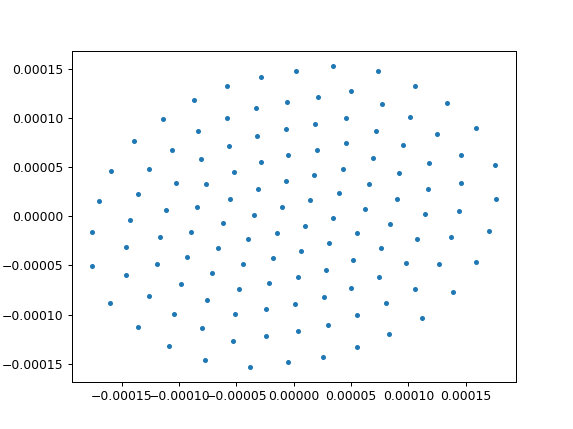

In [7]:
plt.plot(ensemble.x[:, 0], ensemble.x[:, 1], 'o', ms=3);

We need to rotate the cloud so that its major axis are aligned with the coordinate axis:

In [8]:
def rotate(xy, phase):
    return np.column_stack((
            xy[:, 0] * np.cos(phase) - xy[:, 1] * np.sin(phase),
            xy[:, 0] * np.sin(phase) + xy[:, 1] * np.cos(phase)
            ))

<IPython.core.display.Javascript object>


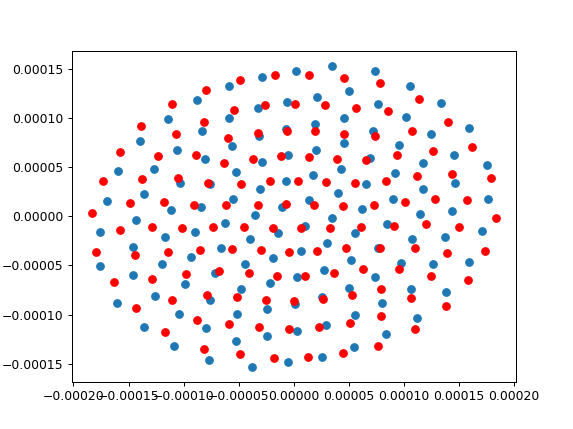

In [9]:
positions = ensemble.x
plt.figure()
plt.plot(positions[:,0], positions[:,1],'o')
rotated = rotate(positions[:,:2], -0.3)
plt.plot(rotated[:,0], rotated[:,1],'ro')

The strongest forces in our system are the Coulomb force and the Lorentz force due to the axial magnetic fields in the Penning trap:

In [10]:
coulomb_force = coldatoms.CoulombForce()

## Axial Penning trap field

One of the essential components of a Penning trap is a strong magnetic fields that bends the ions' trajectories leading to confinement. We represent this force as follows:

In [11]:
class AxialLorentzForce(object):
    """Lorentz force due to axial magnetic field in Penning trap."""
    
    def __init__(self, b_field):
        self.b_field = b_field
        
    def force(self, dt, ensemble, f):
        q = ensemble.ensemble_properties['charge']
        if q is None:
            q = ensemble.particle_properties['charge']
            if q is None:
                raise RuntimeError('Must provide ensemble or per particle charge')
            
        f += dt * self.b_field * np.column_stack(
            (q * ensemble.v[:, 1], -q * ensemble.v[:, 0], np.zeros_like(ensemble.x[:, 0])))

The old Penning trap in the ion storage group at NIST had a field strenght of 4.458 Tesla:

In [12]:
lorentz_force = AxialLorentzForce(4.458)

We check that the magnitude of the resulting force is right by verifying the gyro radius of an ions trajectory.

The expected gyro radius is:
2.09555297581e-07
[[  0.00000000e+00  -7.14250327e-27   0.00000000e+00]]


<IPython.core.display.Javascript object>


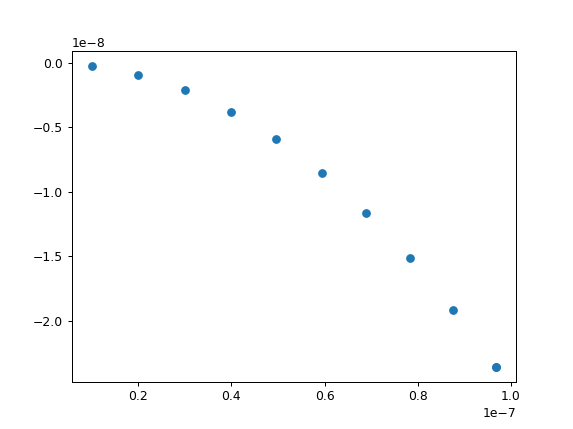

<IPython.core.display.Javascript object>


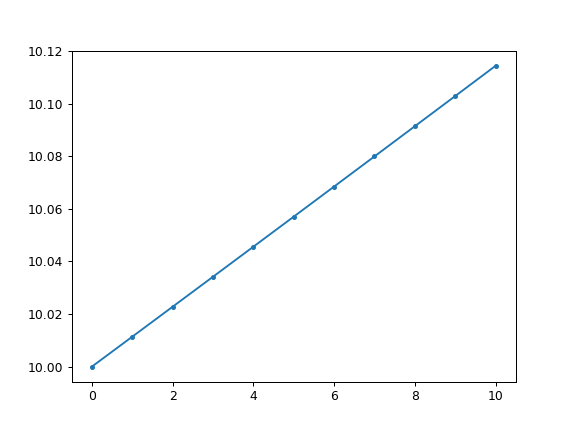

In [36]:
m = ensemble.ensemble_properties['mass']
q = ensemble.ensemble_properties['charge']
B = lorentz_force.b_field
v = 10.0 # m/s
print('The expected gyro radius is:')
print(m * v / (q * B))

test_ensemble = coldatoms.Ensemble(1)
test_ensemble.v[0, 0] = v
test_ensemble.ensemble_properties['mass'] = m
test_ensemble.ensemble_properties['charge'] = q

f = np.zeros_like(test_ensemble.v)
lorentz_force.force(1.0e-9, test_ensemble, f)
print(f)

positions = [test_ensemble.x[0]]
speed = [np.linalg.norm(test_ensemble.v[0])]
dt = 1.0e-9
for i in range(10):
    coldatoms.drift_kick(dt, test_ensemble, [lorentz_force])
    positions.append(np.copy(test_ensemble.x[0]))
    speed.append(np.linalg.norm(test_ensemble.v[0]))

positions = np.array(positions)
plt.figure()
plt.plot(positions[:, 0], positions[:, 1], 'o');
plt.figure()
plt.plot(speed, '.-')

It looks like we have an integrator stability issue here. Initially the radius of curvature appears ok. But the particle is accelerating leading to an increase in the gyro radius over time.

In [13]:
f = np.zeros_like(ensemble.v)
lorentz_force.force(1.0e-9, ensemble, f)
print(ensemble.x[0])
print(ensemble.v[0])
print(f[0])

[  1.00799552e-05  -9.47328408e-06  -9.52882956e-44]
[  2.61945844e+00   2.78756571e+00   2.38067112e-37]
[  1.99101972e-27  -1.87094905e-27   0.00000000e+00]


In [14]:
1.0e-9 * 8.85e-12 * 100.0 * 1.6e-19**2/ (1.0e-5**2)

2.2656e-46

In [15]:
1.0e-9 * 1.6e-19 * 4 * 4.5

2.88e-27

In [25]:
ensemble.ensemble_properties['charge']

1.6021765974585869e-19

The cyclotron frequency is

In [26]:
omega_cyclotron = ensemble.ensemble_properties['charge'] * 4.458 / ensemble.ensemble_properties['mass']

With a period of 

In [27]:
2.0 * np.pi / omega_cyclotron

1.316674766805686e-07

In [31]:
class TrapPotential(object):

    def __init__(self, kz, delta, omega, phi_0):
        self.kz = kz
        self.kx = -(0.5 + delta) * kz
        self.ky = -(0.5 - delta) * kz
        self.phi = phi_0
        self.omega = omega
        
    def force(self, dt, ensemble, f):
        self.phi += self.omega * 0.5 * dt
        
        q = ensemble.ensemble_properties['charge']
        if q is None:
            q = ensemble.particle_properties['charge']
            if q is None:
                raise RuntimeError('Must provide ensemble or per particle charge')

        cphi = np.cos(self.phi)
        sphi = np.sin(self.phi)
        kx = self.kx
        ky = self.ky
        
        f[:, 0] += dt * q * (
            (-kx * cphi * cphi - ky * sphi * sphi) * ensemble.x[:, 0] +
            cphi * sphi * (ky - kx) * ensemble.x[:, 1])
        f[:, 1] += dt * q * (
            cphi * sphi * (ky - kx) * ensemble.x[:, 0] +
            (-kx * sphi * sphi - ky * cphi * cphi) * ensemble.x[:, 1])
        f[:, 2] += -dt * q *self.kz * ensemble.x[:, 2]

        self.phi += self.omega * 0.5 * dt

In [32]:
trap_potential = TrapPotential(2.0 * 1.167e6, 0.0036, 2.0 * np.pi * 44.0e3, 0.3)

In [34]:
f = np.zeros_like(ensemble.x)
trap_potential.force(1.0e-9, ensemble, f)
print(f[0])
print(ensemble.v[0])
print(ensemble.v[0] + f[0]/ensemble.ensemble_properties['mass'])

[  1.88867325e-27  -1.75306697e-27   3.56328693e-65]
[  2.61945844e+00   2.78756571e+00   2.38067112e-37]
[  2.74564344e+00   2.67044076e+00   2.40447796e-37]


# Convergence

First we convince we investigate the error as a function of the time step size to figure out how small of a time step size we need to choose to reasonable accuracy.

In [35]:
def evolve_ensemble(dt, t_max, ensemble, forces):
    t = 0
    while t < t_max:
        coldatoms.drift_kick(dt, ensemble, forces)
        t += dt

<IPython.core.display.Javascript object>


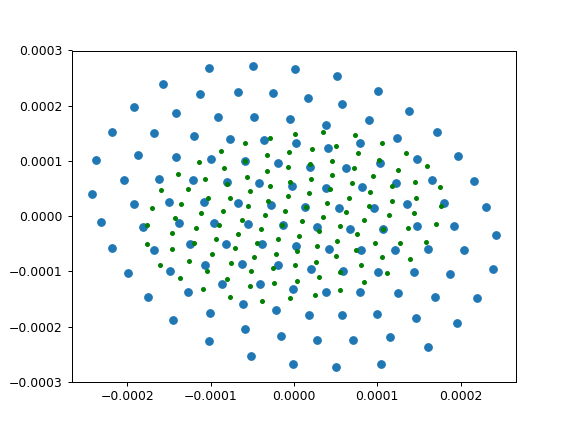

In [47]:
my_ensemble = create_ensemble(input_configuration)
trap_potential.phi = 0.3

evolve_ensemble(5.0e-10, 7.5e-6, my_ensemble, [coulomb_force, lorentz_force, trap_potential])

plt.figure()
plt.plot(my_ensemble.x[:,0], my_ensemble.x[:,1], 'o')
plt.plot(ensemble.x[:,0], ensemble.x[:,1], 'go', ms=3)

<IPython.core.display.Javascript object>


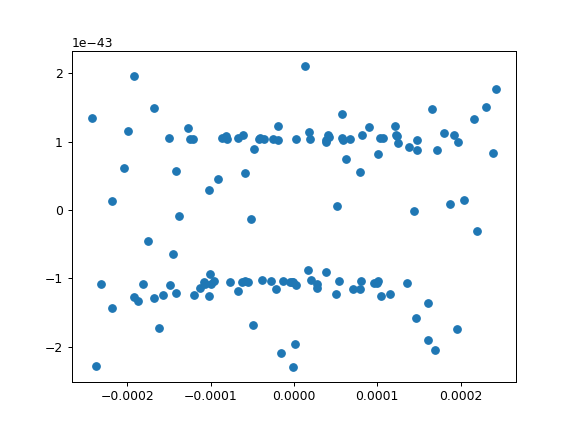

In [48]:
plt.figure()
plt.plot(my_ensemble.x[:,0], my_ensemble.x[:,2], 'o')